In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from transformers import pipeline

In [10]:
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [11]:
dataset_path = "/mnt/c/CP322/IMDB_Dataset.csv"
df = pd.read_csv(dataset_path)
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [12]:
# Creates a vector for each review corresponding to TF-IDF score of each word
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['review']).toarray()

# Convert sentiment labels to numerical values
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])
y = df['sentiment'].values

# Split data into 60% training, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom Dataset class
class IMDBDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Initialize IMDBDataset objects
train_dataset = IMDBDataset(X_train, y_train)
val_dataset = IMDBDataset(X_val, y_val)
test_dataset = IMDBDataset(X_test, y_test)

# Initialize data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [19]:
# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input to hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Raw logits, softmax not needed

# Initialize the model
model = MLP(5000, 512, 2)
model.to(device) #Move model to GPU
print(model)

MLP(
  (fc1): Linear(in_features=5000, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [20]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):
    total_loss = 0.0
    correct = 0
    total = 0

    # Initiate training mode and start training loop
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        outputs = model(features)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1) # retrieves max value for each output prediction to determine classification
        total += labels.size(0) # adds number of samples in current batch
        correct += (predicted == labels).sum().item()

    # Calculate training metrics
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Initiate evaluation mode and calculate validation metrics
    val_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad(): # Ensures gradients are not calculated
        for features, labels in val_loader:
            outputs = model(features)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation metrics
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)
    
    print(f"Epoch {epoch+1}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch 1, Train Loss: 0.3195, Train Acc: 86.57%, Val Loss: 0.2655, Val Acc: 89.18%
Epoch 2, Train Loss: 0.2229, Train Acc: 91.06%, Val Loss: 0.2786, Val Acc: 88.35%
Epoch 3, Train Loss: 0.1974, Train Acc: 92.04%, Val Loss: 0.2918, Val Acc: 87.97%
Epoch 4, Train Loss: 0.1650, Train Acc: 93.41%, Val Loss: 0.3118, Val Acc: 87.62%
Epoch 5, Train Loss: 0.1187, Train Acc: 95.62%, Val Loss: 0.3544, Val Acc: 87.81%
Epoch 6, Train Loss: 0.0663, Train Acc: 98.15%, Val Loss: 0.4217, Val Acc: 87.80%
Epoch 7, Train Loss: 0.0286, Train Acc: 99.46%, Val Loss: 0.5049, Val Acc: 87.67%
Epoch 8, Train Loss: 0.0114, Train Acc: 99.87%, Val Loss: 0.5567, Val Acc: 87.56%
Epoch 9, Train Loss: 0.0050, Train Acc: 99.99%, Val Loss: 0.6174, Val Acc: 87.54%
Epoch 10, Train Loss: 0.0029, Train Acc: 99.99%, Val Loss: 0.6726, Val Acc: 87.66%


In [21]:
# Initiate evaluation mode and calculate testing metrics
correct = 0
total = 0 
predictions = []
model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=['Negative', 'Positive']))

Test Accuracy: 87.29%
Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      4979
    Positive       0.86      0.89      0.88      5021

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



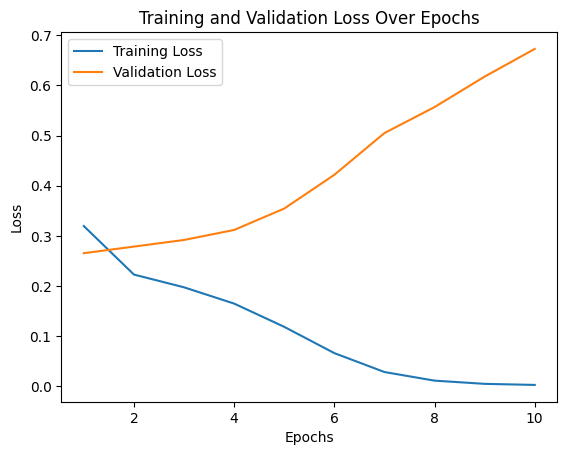

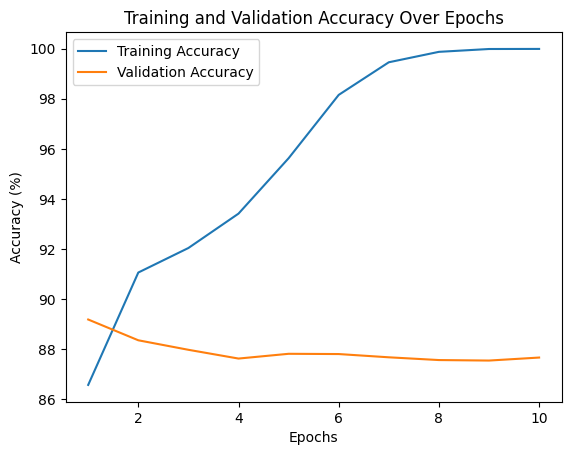

In [22]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure()
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Appears to be overfitting, regularization techniques could be applied

In [7]:
# Redefine X as raw text, not vectorized TF-IDF score
X = df['review'].values
# Re-split data into 60% training, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=device #Run on GPU
)

# Convert 4 and 5 star labels to 1, all else to 0
def convert_sentiment_label(predictions):
    binary_labels = []
    for prediction in predictions:
        if prediction['label'] in ['4 stars', '5 stars']:
            binary_labels.append(1)
        else:
            binary_labels.append(0)
    return binary_labels

# Predict on validation set
val_predictions = sentiment_analyzer(X_val.tolist(), truncation=True) #Truncate to 512 tokens (default)
val_labels = convert_sentiment_label(val_predictions)

# Predict on test set
test_predictions = sentiment_analyzer(X_test.tolist(), truncation=True) #Truncate to 512 tokens (default)
test_labels = convert_sentiment_label(test_predictions)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, val_labels)
test_accuracy = accuracy_score(y_test, test_labels)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("Validation Classification Report:")
print(classification_report(y_val, val_labels, target_names=['Negative', 'Positive']))
print("Test Classification Report:")
print(classification_report(y_test, test_labels, target_names=['Negative', 'Positive']))

Validation Accuracy: 0.85
Test Accuracy: 0.85
Validation Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.94      0.86      5010
    Positive       0.93      0.76      0.83      4990

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

Test Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.94      0.86      4979
    Positive       0.93      0.75      0.83      5021

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000

